# Assignment 3 - SMAI - Multilayer Perceptron Regression 

In [1]:
import os
import sys

# enter the Foldername here:
FOLDERNAME = "/home/richard/play/IIITH/sem5/smai/assignments/assignment-3-fine-man"

if FOLDERNAME is None or not os.path.exists(FOLDERNAME):
    FOLDERNAME = os.getcwd()

PATHNAME = f"{FOLDERNAME}"
sys.path.append(f"{FOLDERNAME}")

# DATA_FOLDER = os.path.join(FOLDERNAME, "SMAI-Dataset-release/IIIT-CFW")
DATA_FOLDER = os.path.join(FOLDERNAME, "datasets")
YAML_FOLDER = os.path.join(FOLDERNAME, "yaml-files/task-3.3/")
print(DATA_FOLDER)
print(YAML_FOLDER)

/home/vanshg/play/IIIITH/sem5/smai/assignments/assignment-3-fine-man/datasets
/home/vanshg/play/IIIITH/sem5/smai/assignments/assignment-3-fine-man/yaml-files/task-3.3/


In [2]:
# some magic so that the notebook will reload external python modules;
# see https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [25]:
import numpy as np
import pandas as pd
import copy
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image
import yaml

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import multilabel_confusion_matrix

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MultiLabelBinarizer
from sklearn.compose import ColumnTransformer

import wandb

In [4]:
from src import *
from src.classifiers import *

## (3.1) - Data Preprocessing

In [5]:
housing_df = pd.read_csv(os.path.join(DATA_FOLDER, "housingdata.csv"))
print(housing_df.shape)
housing_df.head(10)

(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,NaN,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5,311,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5,311,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,NaN,0.524,6.004,85.9,6.5921,5,311,15.2,386.71,17.10,18.9


In [6]:
def preprocess_housing_dataset(housing_df):
    for column_name in housing_df.columns:
        # Calculate the median of the correct column
        median_value = housing_df[column_name].median()

        # Fill NaN value in the current column with the median
        housing_df[column_name].fillna(median_value, inplace=True)
    
    
    return housing_df

In [7]:
housing_df = preprocess_housing_dataset(housing_df)
print(housing_df.shape)

(506, 14)


### (3.1.1) - Describing the Data

In [8]:
housing_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.479140,10.768775,11.028893,0.067194,0.554695,6.284634,68.845850,3.795043,9.549407,408.237154,18.455534,356.674032,12.664625,22.532806
std,8.570832,23.025124,6.704679,0.250605,0.115878,0.702617,27.486962,2.105710,8.707259,168.537116,2.164946,91.294864,7.017219,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.083235,0.000000,5.190000,0.000000,0.449000,5.885500,45.925000,2.100175,4.000000,279.000000,17.400000,375.377500,7.230000,17.025000
50%,0.253715,0.000000,9.690000,0.000000,0.538000,6.208500,76.800000,3.207450,5.000000,330.000000,19.050000,391.440000,11.430000,21.200000
75%,2.808720,0.000000,18.100000,0.000000,0.624000,6.623500,93.575000,5.188425,24.000000,666.000000,20.200000,396.225000,16.570000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### (3.1.2) - Plotting Distribution of Labels

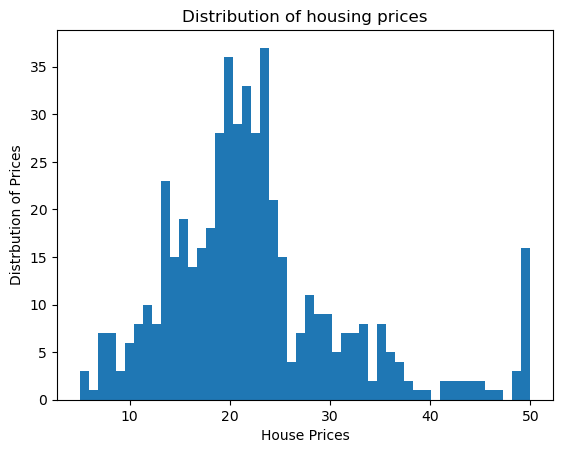

In [9]:
hist, bin_edges = np.histogram(housing_df['MEDV'].to_numpy(), bins=10)

plt.hist(housing_df["MEDV"].to_numpy(), bins=50)
plt.title("Distribution of housing prices")
plt.xlabel("House Prices")
plt.ylabel("Distrbution of Prices")

plt.show()

### (3.1.3) Splitting Data into Train/Val/Test

In [10]:
X = housing_df.iloc[:, :-1].to_numpy()
y = housing_df.iloc[:, -1].to_numpy()
print(X.shape, y.shape)

(506, 13) (506,)


In [11]:
# Train, Val, Test split
# 70-10-20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.33, random_state=42
)

print(f"Size of Training Data: {X_train.shape}, {y_train.shape}")
print(f"Size of Validation Data: {X_val.shape}, {y_val.shape}")
print(f"Size of Testing Data: {X_test.shape}, {y_test.shape}")

Size of Training Data: (354, 13), (354,)
Size of Validation Data: (51, 13), (51,)
Size of Testing Data: (101, 13), (101,)


### (3.1.4) Standerizing the data

In [12]:
# Standarizing the data
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [13]:
print(f"Size of Training Data: {X_train.shape}, {y_train.shape}")
print(f"Size of Validation Data: {X_val.shape}, {y_val.shape}")
print(f"Size of Testing Data: {X_test.shape}, {y_test.shape}")

Size of Training Data: (354, 13), (354,)
Size of Validation Data: (51, 13), (51,)
Size of Testing Data: (101, 13), (101,)


## (3.3) Hyper-parameter Tuning using Wandb

In [31]:
# testing out sweep using a single config
config = {
    "method": "grid",
    "name": "sgd-grid-search",
    "parameters": {
        "criterion": "MSE",
        "model": {
            "input_dim" : 13,
            "activation": "relu",
            "hidden_dims1": 10,
            "num_classes": 1,
        },
        "optimizer": {
            "update_rule" : "adam",
            "learning_rate": 1e-2,
        },
        "training": {
            "update_type": "minibatch",
            "batch_size": 32,
            "epochs": 1000,
            "print_every": 1000,
            "calc_accuracy": False,
            "log_wandb": True,
            # "verbose": True
        }
    }
}

In [15]:
np.random.seed(42)

param_config = config["parameters"]
# getting the model, criterion and optimizer
model = get_model(param_config["model"])
print(model.parameters().keys())
criterion = get_criterion(param_config["criterion"])
optimizer = get_optimizer(param_config["optimizer"], model)

# training config
train_config = param_config["training"]

train_loss_history, val_loss_history = train(
    model, criterion, optimizer, X_train, y_train, X_val, y_val, **train_config)

# best_model = trigger_training(config["parameters"], X_train, y_train, X_val, y_val)

dict_keys(['W1', 'b1', 'W2', 'b2'])
Epoch: 1 |  Train loss: 401.2573 | Val loss: 465.4018

Epoch: 2 |  Train loss: 279.2186 | Val loss: 325.2338

Epoch: 3 |  Train loss: 180.7680 | Val loss: 214.9920

Epoch: 4 |  Train loss: 113.1686 | Val loss: 140.3889

Epoch: 5 |  Train loss: 82.6394 | Val loss: 106.3871

Epoch: 6 |  Train loss: 66.5285 | Val loss: 93.2593

Epoch: 7 |  Train loss: 56.4294 | Val loss: 87.9818

Epoch: 8 |  Train loss: 51.1229 | Val loss: 85.5507

Epoch: 9 |  Train loss: 46.7816 | Val loss: 80.0999

Epoch: 10 |  Train loss: 43.1420 | Val loss: 73.4752

Epoch: 11 |  Train loss: 39.5588 | Val loss: 66.6714

Epoch: 12 |  Train loss: 36.6973 | Val loss: 63.0194

Epoch: 13 |  Train loss: 34.0041 | Val loss: 57.3562

Epoch: 14 |  Train loss: 31.3299 | Val loss: 50.9019

Epoch: 15 |  Train loss: 29.0564 | Val loss: 45.6673

Epoch: 16 |  Train loss: 27.4545 | Val loss: 41.0590

Epoch: 17 |  Train loss: 25.4219 | Val loss: 39.1285

Epoch: 18 |  Train loss: 24.1331 | Val loss: 3

In [ ]:
wandb.init(
    project="smai-assignment3-task3",
    config=config
)

wandb.run.name = "testing"
trigger_training(config["parameters"], X_train, y_train, X_val, y_val)
wandb.finish()

In [14]:
def sweep_agent_manager():
    global X_train, y_train, X_val, y_val
    run = wandb.init()
    config = re_nest_config(dict(wandb.config))
    # setting the wandb run name for the current config
    run_name = make_wandb_run_name(config)
    print(f"Run Name: {run_name}")
    run.name = run_name
    # start the training
    trigger_training(config, X_train, y_train, X_val, y_val)

In [48]:
print(sweep_configuration)

{'method': 'grid', 'name': 'single-layer-sgd-grid-search', 'parameters': {'criterion': {'value': 'MSE'}, 'model.input_dim': {'value': 13}, 'model.activation': {'values': ['relu', 'sigmoid', 'tanh']}, 'model.hidden_dims1': {'values': [8, 16, 32, 64]}, 'model.num_classes': {'value': 1}, 'optimizer.update_rule': {'values': ['sgd']}, 'optimizer.learning_rate': {'values': [0.0001, 0.0005, 0.001, 0.01, 0.1]}, 'training.update_type': {'values': ['minibatch', 'batch', 'stochastic']}, 'training.batch_size': {'values': [16, 32, 64, 128]}, 'training.epochs': {'value': 500}, 'training.calc_accuracy': {'value': False}, 'training.log_wandb': {'values': [True]}, 'training.verbose': {'value': False}}}


In [15]:
f = open(os.path.join(YAML_FOLDER, "single-layer-grid-search.yaml"), "r")

sweep_configuration = yaml.safe_load(f)
print(sweep_configuration)

{'method': 'grid', 'project': 'smai-assignment3-task2', 'name': 'single-layer-grid-search', 'parameters': {'criterion': {'value': 'MSE'}, 'model.input_dim': {'value': 13}, 'model.activation': {'values': ['relu', 'sigmoid', 'tanh']}, 'model.num_layers': {'value': 1}, 'model.hidden_dims1': {'values': [8, 16, 32, 64]}, 'model.num_classes': {'value': 1}, 'optimizer.update_rule': {'values': ['adam', 'sgd']}, 'optimizer.learning_rate': {'values': [0.0001, 0.0005, 0.001, 0.01]}, 'training.update_type': {'values': ['minibatch', 'batch', 'stochastic']}, 'training.batch_size': {'values': [8, 16, 32, 64]}, 'training.epochs': {'value': 500}, 'training.log_wandb': {'value': True}, 'training.calc_accuracy': {'value': False}, 'training.verbose': {'value': False}}}


In [16]:
sweep_id = wandb.sweep(sweep=sweep_configuration, project="smai-assignment3-task3")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: xnt01pmd
Sweep URL: https://wandb.ai/vanshg/smai-assignment3-task3/sweeps/xnt01pmd


In [ ]:
wandb.agent(sweep_id=sweep_id, function=sweep_agent_manager)

## (3.4) Evaluating Model

In [14]:
# Best Hyperparameters found using Wandb
config = {
    "parameters": {
        "criterion": "MSE",
        "model": {
            "input_dim" : 13,
            "activation": "relu",
            "num_layers": 1,
            "hidden_dims1": 16,
            "num_classes": 1,
        },
        "optimizer": {
            "update_rule" : "sgd",
            "learning_rate": 0.01,
        },
        "training": {
            "update_type": "minibatch",
            "batch_size": 16,
            "epochs": 500,
            "print_every": 1000,
            "calc_accuracy": False,
            "verbose": True
        }
    }
}

best_model = trigger_training(config["parameters"], X_train, y_train, X_val, y_val)

1
dict_keys(['W1', 'b1', 'W2', 'b2'])
<function MSELoss at 0x7f6ade7b70a0>
Number of Iterations Per Epoch: 23
Epoch: 1 |  Train loss: 36.8907 | Val loss: 48.9935

Epoch: 2 |  Train loss: 64.3557 | Val loss: 60.6529

Epoch: 3 |  Train loss: 48.8387 | Val loss: 52.1529

Epoch: 4 |  Train loss: 31.8695 | Val loss: 41.9256

Epoch: 5 |  Train loss: 27.9885 | Val loss: 28.3298

Epoch: 6 |  Train loss: 31.8144 | Val loss: 32.7744

Epoch: 7 |  Train loss: 19.0079 | Val loss: 30.8631

Epoch: 8 |  Train loss: 23.4938 | Val loss: 31.6953

Epoch: 9 |  Train loss: 17.7724 | Val loss: 22.9875

Epoch: 10 |  Train loss: 13.7641 | Val loss: 19.3578

Epoch: 11 |  Train loss: 18.5461 | Val loss: 32.8306

Epoch: 12 |  Train loss: 24.2411 | Val loss: 27.3765

Epoch: 13 |  Train loss: 49.5855 | Val loss: 77.3675

Epoch: 14 |  Train loss: 43.4749 | Val loss: 45.8414

Epoch: 15 |  Train loss: 36.0683 | Val loss: 50.0790

Epoch: 16 |  Train loss: 10.7064 | Val loss: 19.7287

Epoch: 17 |  Train loss: 15.2864 | 

In [26]:
# Calculating loss on Test set
criterion = get_criterion("MSE")

eval_config = {
    "criterion": criterion,
    "return_accuracy": False,
    "return_loss": True
}

best_model.eval()
y_test_pred = best_model.forward(X_test)

mse_loss = mean_squared_error(y_test, y_test_pred)
rmse_loss = mean_squared_error(y_test, y_test_pred, squared=False)
r_squared_score = r2_score(y_test, y_test_pred)

print(f"Metrics on Test set:")
print(f"MSE Loss: {mse_loss:.4f}")
print(f"RMSE Loss: {rmse_loss:.4f}")
print(f"R2 Score: {r_squared_score:.4f}")

Metrics on Test set:
MSE Loss: 11.6963
RMSE Loss: 3.4200
R2 Score: 0.8052
